# Generating Random Correlation Matrices
## Marseille, June 14: Notebook for Lecture 4

In [18]:
#import Pkg; Pkg.add("Latexify")
using LinearAlgebra
using Latexify
using Random
using Distributions
using Random

## Part A. Naive Method: Random $C_{ij}\in (-1,1)$, reject if $\lambda_{\min}(C)<0$.

In [19]:
# Create candidate correlation matrix, C
# Elements are uniformly distributed on [-1,1]
function RandomCorrMatrixUniform(n)
    C = Symmetric(ones(n,n))
    m = 0
    while eigmin(C) <= 0
        for i = 1:n-1                           
            for j = i+1:n
                    C.data[i,j] = (2*rand(1) .- 1.0)[1]
            end
        end
        m += 1
    end  
    return m, C
end

RandomCorrMatrixUniform (generic function with 1 method)

In [20]:
n = 3
(m,C) = RandomCorrMatrixUniform(n)
print("n = $(n). Success with m'th C, where m = $(m)")
latexify(C;  fmt = "%.3g")

n = 3. Success with m'th C, where m = 1

L"\begin{equation}
\left[
\begin{array}{ccc}
1 & -0.384 & -0.873 \\
-0.384 & 1 & 0.653 \\
-0.873 & 0.653 & 1 \\
\end{array}
\right]
\end{equation}
"

In [21]:
n = 4
(m,C) = RandomCorrMatrixUniform(n)
print("n = $(n). Success with m'th C, where m = $(m)")
latexify(C;  fmt = "%.3g")

n = 4. Success with m'th C, where m = 1

L"\begin{equation}
\left[
\begin{array}{cccc}
1 & 0.267 & 0.26 & 0.646 \\
0.267 & 1 & 0.386 & 0.07 \\
0.26 & 0.386 & 1 & 0.275 \\
0.646 & 0.07 & 0.275 & 1 \\
\end{array}
\right]
\end{equation}
"

In [22]:
n = 5
(m,C) = RandomCorrMatrixUniform(n)
print("n = $(n). Success with m'th C, where m = $(m)")
latexify(C;  fmt = "%.3g")

n = 5. Success with m'th C, where m = 18

L"\begin{equation}
\left[
\begin{array}{ccccc}
1 & -0.0504 & 0.805 & 0.467 & -0.149 \\
-0.0504 & 1 & 0.311 & 0.555 & -0.14 \\
0.805 & 0.311 & 1 & 0.8 & -0.263 \\
0.467 & 0.555 & 0.8 & 1 & -0.262 \\
-0.149 & -0.14 & -0.263 & -0.262 & 1 \\
\end{array}
\right]
\end{equation}
"

## How about larger $n$

In [23]:
n = 6
(m,C) = RandomCorrMatrixUniform(n)
print("Success with m'th C, where m = $(m)")
latexify(C;  fmt = "%.3g")

Success with m'th C, where m = 3292

L"\begin{equation}
\left[
\begin{array}{cccccc}
1 & 0.13 & -0.343 & 0.519 & -0.419 & -0.444 \\
0.13 & 1 & -0.478 & -0.726 & -0.713 & 0.0823 \\
-0.343 & -0.478 & 1 & 0.0915 & 0.664 & -0.409 \\
0.519 & -0.726 & 0.0915 & 1 & 0.342 & -0.269 \\
-0.419 & -0.713 & 0.664 & 0.342 & 1 & -0.391 \\
-0.444 & 0.0823 & -0.409 & -0.269 & -0.391 & 1 \\
\end{array}
\right]
\end{equation}
"

In [24]:
n = 7
(m,C) = RandomCorrMatrixUniform(n)
print("Success with m'th C, where m = $(m)")
latexify(C;  fmt = "%.3g")

Success with m'th C, where m = 7576

L"\begin{equation}
\left[
\begin{array}{ccccccc}
1 & 0.172 & -0.0735 & 0.409 & -0.332 & -0.138 & -0.287 \\
0.172 & 1 & 0.793 & 0.148 & -0.282 & 0.213 & -0.217 \\
-0.0735 & 0.793 & 1 & 0.144 & 0.00112 & 0.244 & -0.264 \\
0.409 & 0.148 & 0.144 & 1 & 0.0723 & -0.0871 & -0.967 \\
-0.332 & -0.282 & 0.00112 & 0.0723 & 1 & -0.656 & -0.235 \\
-0.138 & 0.213 & 0.244 & -0.0871 & -0.656 & 1 & 0.199 \\
-0.287 & -0.217 & -0.264 & -0.967 & -0.235 & 0.199 & 1 \\
\end{array}
\right]
\end{equation}
"

## Part B. Much smarter ways to do this
E.g. Beta-distributed Partial Correlations: Joe (2006).

## Generating Random Correlation Matrices with New Method

In [25]:
# inverse operator. dim(g)=dx1 where d must equal n(n-1)/2 for some integer n
function veclInv(g)
    d = size(g,1)
    n = convert(Int64,0.5*(1+sqrt(1+8*d)))
    G = Symmetric(zeros(n,n))
    l = 0
    for i = 1:n-1, j = i+1:n
        @inbounds G.data[i,j] = g[l +=1]
    end
    return G
end
function GFTstep!(G,Δx)   # the "!" is important for speed. So is "." in code below. Modifying memory
    Δx .= log.(diag(exp(G)))
    for i∈1:length(Δx)
        G[i,i] -= Δx[i]   # update diagonal elements
    end
end
function GFT(G, ϵ::Float64 = 1e-10)
    n = size(G,1)
    δ = Inf; N = -1; Δx = ones(n,1)   # initialize
    while δ > sqrt(n)*ϵ
        GFTstep!(G,Δx)                # GFTstep updated diagonal of A, the
        δ = norm(Δx)                  # convergence is defined by δ
        N = N + 1
    end
    return Symmetric(exp(G)),N
end

GFT (generic function with 2 methods)

In [26]:
n = 100
d = convert(Int64,n*(n-1)/2)
G = veclInv(randn(d,1)/sqrt(n/2))

100×100 Symmetric{Float64, Matrix{Float64}}:
  0.0        -0.107013     0.357396    …  -0.0577003   -0.0763441
 -0.107013    0.0         -0.0527849      -0.277116    -0.00630679
  0.357396   -0.0527849    0.0             0.1904       0.00193311
 -0.119382   -0.0796809    0.195065       -0.00867769  -0.0154898
  0.152728   -0.0859251   -0.1412         -0.0493227   -0.0685003
  0.10027     0.106715    -0.0368031   …   0.00284481  -0.0991541
 -0.25225     0.00995981  -0.378896       -0.136909     0.0837861
 -0.130717    0.0342133    0.161493       -0.101831     0.0235038
 -0.174584   -0.0536571    0.014514       -0.257285     0.202816
  0.0474813   0.0974556   -0.0477168       0.388543    -0.0374466
 -0.0650361   0.0413472   -0.179543    …  -0.0711081    0.0462946
 -0.0656245   0.0740081   -0.318847        0.180336    -0.233341
  0.0946604  -0.0524486   -0.0233963      -0.073885     0.100182
  ⋮                                    ⋱               
  0.0310587   0.117461    -0.0421317      

In [27]:
(C,N) = GFT(G)
latexify(C; fmt =  "%.3g")

"\\begin{equation}\n\\left[\n\\begin{array}{cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc}\n1 & -0.0397 & 0.183 & -0.0799 & 0.0839 & 0.13 & -0.165 & -0.0526 & -0.167 & 0.103 & -0.111 & -0.102 & 0.184 & -0.169 & 0.0398 & 0." ⋯ 89424 bytes ⋯ "23 & -0.0292 & -0.116 & -0.209 & 0.0448 & 0.0636 & 0.0651 & -0.0656 & 0.00727 & 0.0568 & -0.0816 & 0.0292 & -0.244 & 0.0564 & -0.069 & -0.00199 & -0.0244 & -0.0109 & 0.174 & 0.222 & -0.185 & -0.0464 & -0.0931 & 0.0608 & 0.0999 & 1 \\\\\n\\end{array}\n\\right]\n\\end{equation}\n"

## Part C. Use Block Structures to Generate Even Larger Matrices

In [28]:
# **Function that creates the Q-matrix for a Block Correlation matrix
function MakeQ(nK)   # nK is vector with block dimensions
    K = size(nK,1)   # number of blocks
    n = sum(nK)      # dimension of C matrix
    Q = zeros(n,n)
    i₀=0
    for k in 1:K
        nₖ = nK[k]
        v  = ones(nₖ,1)./ √nₖ
        Q[i₀+1:i₀+nₖ,k] = v
        if nₖ>1
            v⊥ = eigvecs(I(nₖ)-v*v')[:,2:end]
            Q[i₀+1:i₀+nₖ,K+i₀+1-(k-1):K+i₀+nₖ-1-(k-1)] = v⊥
        end
        i₀ = i₀ + nₖ
    end
    Q
end      

MakeQ (generic function with 1 method)

# Efficiently done with Canonical Form for $G=\log(C)$
$G=\log(C)$ has the same block structure, with diagonal blocks
$$
G_{[k,k]} = 
    \left[
        \begin{array}{cccc}
            y_k &  \gamma_{k,k}& \cdots & \gamma_{k,k}\\
            \gamma_{k,k}  & y_k & \ddots & \vdots\\
            \vdots  & \ddots & \ddots & \gamma_{k,k} \\
            \gamma_{k,k}  & \cdots &\gamma_{k,k}  & y_k
        \end{array}
    \right]\in\mathbb{R}^{n_k\times n_k},
$$

where $y_k$, $k=1,\ldots,K$ denotes the unique diagonal elements of $G$

$$ \mathrm{diag}(G) = (y_1,\ldots,y_1,\ldots,y_K,\ldots,y_K)^\prime.$$ 

Thus, $G$ has canonical form 

$$G=\log(C) = Q\tilde{D}Q^{\prime},\qquad 
    \tilde{D}=\left[\begin{array}{cccc}
        \tilde{A}(y) & 0 & \cdots & 0\\
0 & (y_1-\gamma_{11})I_{n_{1}-1} & \ddots & \vdots\\
\vdots & \ddots & \ddots & 0\\
0 & \cdots & 0 & (y_K-\gamma_{KK})I_{n_{K}-1}
\end{array}\right]$$

where $\tilde{A}$ is a $K\times K$ matrix, with elements

$$\tilde{A}(y)_{kl}=\begin{cases}
\gamma_{kk}(n_{k}-1)+ y_k & k=l,\\
\gamma_{kl}\sqrt{n_{k}n_{l}} & i\neq j.
\end{cases}$$

## Solve for $y$ from $\tilde{A}$

We can solve for $x^\ast$, such that $\exp G[x^\ast]$ is a correlation matrix using contraction steps. 

We known that
$$ x^\ast = (y^\ast_1,\ldots,y^\ast_1,\ldots,y^\ast_K,\ldots,y^\ast_K)^\prime,$$ where $y^\ast_1,\ldots,y^\ast_K,$ are 
repeated $n_1,\ldots,n_K$ times, respectively.

If we initialize with a vector with the same structure

$$ x^{(0)} = (y^{(0)}_1,\ldots,y^{(0)}_1,\ldots,y^{(0)}_K,\ldots,y^{(0)}_K)^\prime$$

We can undertake the exact same steps using matrices of smaller dimensions, $K\times K$ instead of $n\times n$. 

Because, the $k$-th diagonal block of $\exp G[x]$ is given by
$$
[\exp(\tilde{A}(y))]_{k,k} P_{n_k} + e^{y_{k}-\gamma_{kk}}(I-P_{n_k}),\qquad
P_{n_k}  = \left[\begin{array}{ccc}
            \tfrac{1}{n_{k}}&  \cdots & \tfrac{1}{n_{k}}\\
            \vdots  & \ddots & \vdots \\
            \tfrac{1}{n_{k}}  & \cdots & \tfrac{1}{n_{k}}
        \end{array}\right],
$$

such that we need 
$$
1= \frac{[\exp(\tilde{A}(y))]_{k,k}}{n_k} + e^{y_{k}-\gamma_{kk}}(\frac{n_k-1}{n_k}),
$$

and the contraction steps (in GFT algorithm) are identical to 

$$
y_k^{(n+1)} = y_k^{(n)} 
          - \log \left(\frac{[\exp(\tilde{A}(y^{(n)}))]_{k,k}}{n_k} + e^{y^{(n)}_{k}-\gamma_{kk}}(\frac{n_k-1}{n_k})\right).
$$

Notice that 
$$\tilde{A}(y) = \tilde{A}^0 + \mathrm{diag}(y),\qquad \text{where}\quad 
\tilde{A}^0_{kl} =\begin{cases}
\gamma_{kk}(n_{k}-1) & k=l,\\
\gamma_{kl}\sqrt{n_{k}n_{l}} & i\neq j.
\end{cases} $$

## Generate Random [Block] Correlation Matrices

In [29]:
# generates the block correlation matrix from gammas (in Gc) using block sizes in nK
# in: Gc  -- KxK symmetric matrix, with G_kl = G_lk = γ_kl
#     nK  -- Kx1 vector with integers defining block sizes
#     tol -- (optional) tolerance   
function Gamma2BlockC(Gc,nK,tol::Float64 = 1e-12)
    Gc = Symmetric(Gc)
    K  = size(Gc,1)      # number of blocks
    n  = sum(nK)         # size of matrix
    Λₙ = Diagonal(sqrt.(nK))
    Ã  = Symmetric(Λₙ*Gc*Λₙ-Diagonal(diag(Gc)))  # This is A-tilde
    y  = zeros(K)
    Δy = ones(K) 
    while sum(abs.(Δy))>tol
        Δy .= real(log.(diag(exp(Ã))./nK .+ (1.0 .- 1.0./nK).*exp.(y-diag(Gc))) )
        y -= Δy
        for k = 1:K
            Ã[k,k] -= Δy[k]   # update diagonal elements
        end
    end 
    D  = zeros(n,n)                    # Create D matrix for C
    D[1:K,1:K] = exp(Ã)      
        idx = K
    for k in 1:K
        if nK[k] > 1
            dₖ = exp(y[k]-Gc[k,k])
            for i = idx+1:idx+nK[k]-1
                D[i,i] = dₖ
                idx +=1
            end
        end
    end
    Q = MakeQ(nK)
    Symmetric(Q*D*Q')
end    

Gamma2BlockC (generic function with 2 methods)

In [30]:
K = 6
Gc = randn(K,K) .+ 0.6
for k=1:K-1, l=k+1:K
    Gc[k,l] = Gc[l,k]
end
#nK = [k for k = 1:K]
nK = rand(Poisson(4),K) .+ 1
print("n = ",sum(nK),"     nK = ",nK,"\n")
Gc = (Gc ./ sqrt(sum(nK)))./2
C = Gamma2BlockC(Gc,nK)
println("λmin = ",eigmin(C))
latexify(C; fmt = "%.2g")

n = 29     nK = [3, 2, 6, 5, 5, 8]
λmin = 0.025171953194755303


"\\begin{equation}\n\\left[\n\\begin{array}{ccccccccccccccccccccccccccccc}\n1 & 0.18 & 0.18 & 0.25 & 0.25 & 0.33 & 0.33 & 0.33 & 0.33 & 0.33 & 0.33 & 0.15 & 0.15 & 0.15 & 0.15 & 0.15 & -0.0056 & -0.0056 & -0.0056 & -0.0056 & -0.0056 & 0.24 & 0.24 & 0.24 & 0.24 & 0.24 & 0.24 & " ⋯ 5517 bytes ⋯ "& 0.34 & 0.34 & 0.34 & 1 & 0.34 \\\\\n0.24 & 0.24 & 0.24 & 0.15 & 0.15 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.13 & 0.13 & 0.13 & 0.13 & 0.13 & -0.11 & -0.11 & -0.11 & -0.11 & -0.11 & 0.34 & 0.34 & 0.34 & 0.34 & 0.34 & 0.34 & 0.34 & 1 \\\\\n\\end{array}\n\\right]\n\\end{equation}\n"

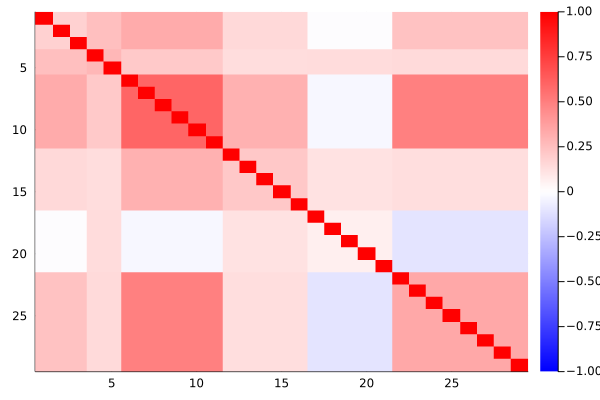

In [31]:
using Plots, ColorSchemes
heatmap(C,  c = :bwr, clims=(-1,1), yflip=:true)

# Even larger C [without Block Structure]

## Idea: Shuffle small-K block matrices and combine

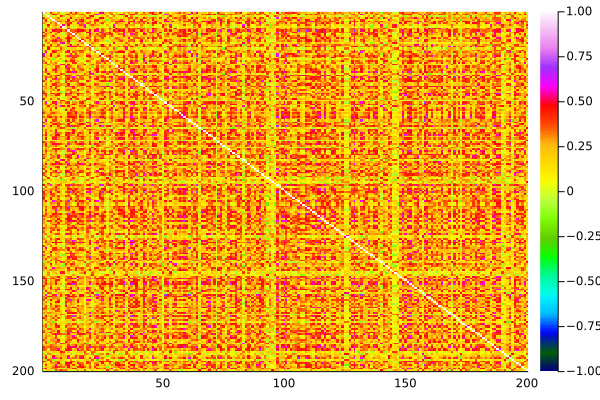

In [32]:
function ShuffleC(C)  # shuffling a C 
    n = size(C,1)
    idxvec = [r for r = 1:n]
    shuffle!(idxvec)
    return C[idxvec,idxvec] 
end

n   = 200
K   = 3  
nhalf = floor(Int,n/2)

S = 20
C0 = zeros(n,n)
Cs = zeros(n,n)
for s = 1:S                                       # Make a bunch of random block Cs, shuffle them and take convex combination
    Gc = 10*randn(K,K)
    for k=1:K-1, l=k+1:K
        Gc[k,l] = Gc[l,k]
    end
    Gc = (Gc ./ sqrt(n))
    n1 = rand(1:nhalf)
    n2 = rand(1:nhalf)
    nK = [n1 , n2, n-n1-n2]
    Cs = Gamma2BlockC(Gc,nK)                       # make a random block D
    C0 += ShuffleC(Cs).*(2*s/(S*(S+1)))            # shuffle it and add
end
C0
                 
heatmap(C0,  c = :gist_ncar, clims=(-1,1), yflip=:true,fmt = :png)

In [33]:
eigmin(C0)

0.15961517926037566